In [128]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from scipy.stats import entropy, wasserstein_distance, truncnorm, pearson3, entropy
import emcee
from tqdm import tqdm
import scipy.stats as sp
mpl.rcParams['figure.dpi'] = 500

In [129]:
os.chdir('/Users/braydennoh/Documents/Gatech/20221122_1')
sediment_data, x_values, y_values, ax1_values, ax2_values, ax3_values = [], [], [], [], [], []
with open('1.txt', 'r') as file:
    current_sediment = {'c': [], 'r': []}
    for line in file:
        line = line.strip()
        parts = line.split(':')
        key, value = parts[0], float(parts[1]) if len(parts) > 1 else None
        if key in current_sediment and value is not None:
            current_sediment[key].append(value)
        elif line == '' and current_sediment:
            sediment_data.append(current_sediment)
            current_sediment = {'c': [], 'r': []}
for sediment in sediment_data:
    x_values.extend(sediment['c'][:2])
    ax1_values.append(sediment['r'][0])
    ax2_values.append(sediment['r'][1])
    ax3_values.append(sediment['r'][2])
major_axes = [math.sqrt(x**2 + y**2 + z**2) for x, y, z in zip(ax1_values, ax2_values, ax3_values)]

In [163]:
def hkm(parm):  
    mean_log = parm[0]
    std_log = parm[1]
    skew = parm[2]
    rvs_pearson3 = pearson3.rvs(skew=skew, loc=mean_log, scale=std_log, size=100)
    input_shear_stress_array = np.exp(rvs_pearson3)
    mediandiameter = 1
    num_sediments_per_segment = 1000
    num_segments = 100
    total_sediments = num_sediments_per_segment * num_segments
    diameters_in_range_all_iterations = []
    for iteration, input_shear_stress in enumerate(input_shear_stress_array):
        np.random.seed(42)  # Set a fixed random seed
        diameters = np.random.uniform(0.01, 2.00, total_sediments)  # This will now be the same for each iteration
    mediandiameter = 1
    shield = 0.05
    specificg = 2
    scaled_r_values = [shield * (specificg - 1) * 1000 * 9.8 * r for r in diameters]
    x_coordinates = np.concatenate([np.random.uniform(-10 - i * 10, -i * 10, num_sediments_per_segment) for i in range(num_segments)])
    y_coordinates = np.tile(np.random.uniform(0, 10, num_sediments_per_segment), num_segments)
    diameters_in_range_all_iterations = []
    for iteration, input_shear_stress in tqdm(enumerate(input_shear_stress_array), total=len(input_shear_stress_array)):
        move_indices = np.where(np.array(scaled_r_values) < input_shear_stress)[0]
        move_diameters = np.array(diameters)[move_indices]
        diameterratio = move_diameters/mediandiameter
        L_values = 1.77 * (1 - np.log10(diameterratio))**1.35
        Distance = L_values
        x_coordinates[move_indices] += Distance
        indices_in_range = np.where((x_coordinates >= 50) & (x_coordinates < 60))[0]
        diameters_in_range = np.array(diameters)[indices_in_range]
        diameters_in_range_all_iterations.extend(diameters_in_range.tolist())
    return diameters_in_range_all_iterations
def stress(parm):  
    mean_log = parm[0]
    std_log = parm[1]
    skew = parm[2]
    rvs_pearson3 = pearson3.rvs(skew=skew, loc=mean_log, scale=std_log, size=100)
    return np.exp(rvs_pearson3)

In [131]:
def log_lik(parm, data):
    sim = hkm(parm)
    if len(sim) == 0:
        return -np.inf
    hist_sim, _ = np.histogram(sim, bins=100, density=True)
    hist_data, _ = np.histogram(data, bins=100, density=True)
    hist_sim += 1e-10
    hist_data += 1e-10
    err = entropy(hist_sim, hist_data)
    return -0.5 * np.sum(err**2)
def log_prior(parm):
    mean_log, std_log, skew = parm
    # Add constraints for your parameters
    if 0 < mean_log < 20 and 0 < std_log < 20 and -3 < skew < 3:
        return 0.0
    return -np.inf
def log_post(parm, data):
    lp = log_prior(parm)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_lik(parm, data)

In [132]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
ndim, nwalkers = 3, 100
X1 = get_truncated_normal(mean=1, sd=3, low=0, upp=20)
X2 = get_truncated_normal(mean=1, sd=2, low=0, upp=20)
X3 = get_truncated_normal(mean=0, sd=5, low=-10, upp=10)
p0 = np.ones([nwalkers, ndim])
p0[:,0] = X1.rvs(size = nwalkers)
p0[:,1] = X2.rvs(size = nwalkers)
p0[:,2] = X3.rvs(size = nwalkers)
samples_runs = 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args = [major_axes])
sampler.run_mcmc(p0, samples_runs, progress=True)
samp = sampler.get_chain()
samp_reshaped = samp.reshape(samp.shape[0], -1)
sampsubset = samp[0:samples_runs,:,:]
samp2d = sampsubset.reshape(sampsubset.shape[0]*sampsubset.shape[1],3)
samp2d.shape
samp2d

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 332.69it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 343.77it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 290.65it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 328.93it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 333.65it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 309.03it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 352.95it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 361.39it/s]

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 345.92it/s]

100%|███████████████████████

array([[ 2.45139468e+00,  1.61159136e+00, -2.00326039e+00],
       [ 6.83173516e+00,  1.51430309e+00,  6.71654380e+00],
       [ 1.42625510e+00,  6.00140402e+00, -6.45431026e+00],
       ...,
       [ 3.19672934e+00,  1.68987351e+01, -1.95177398e-01],
       [ 5.08205459e-03,  1.86573383e+00,  7.85687180e+00],
       [ 1.65349475e+00,  3.80420722e-01,  2.41709992e+00]])

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 306.62it/s]


<Axes: ylabel='Density'>

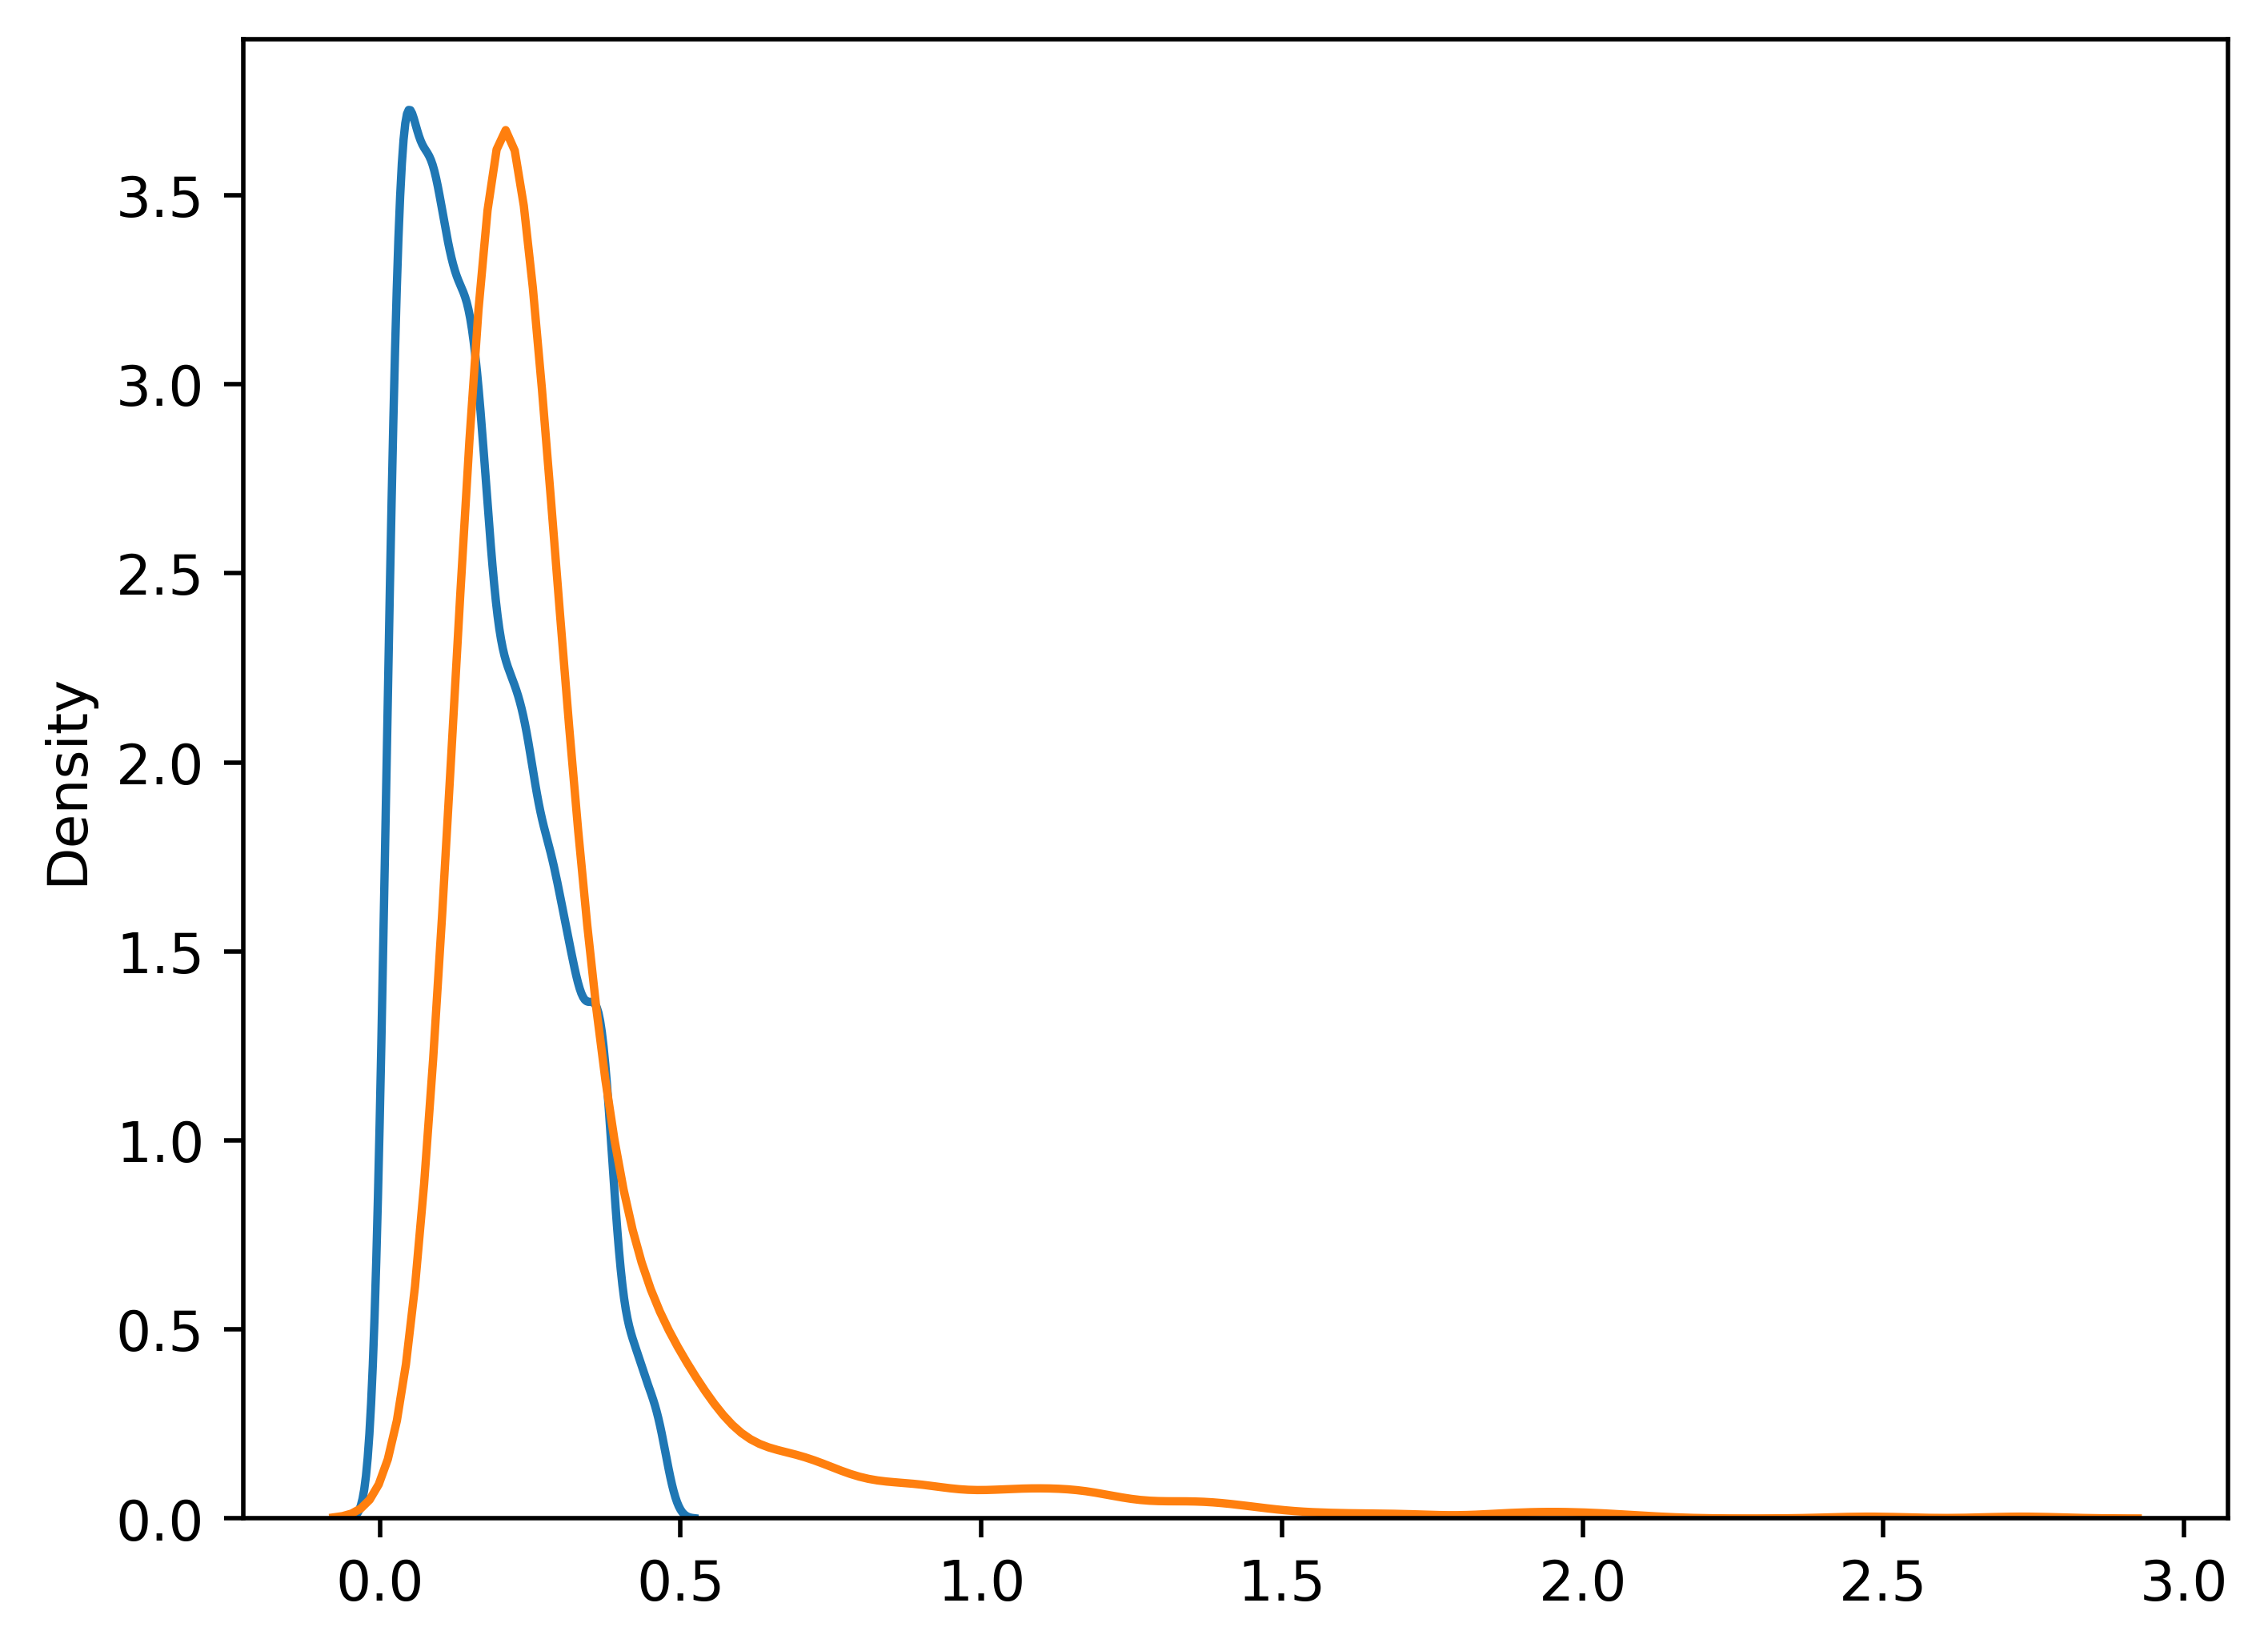

In [164]:
diameters_in_range_all_iterations = hkm([meanlog, stdlog, skewlog])
sns.kdeplot(diameters_in_range_all_iterations)
sns.kdeplot(major_axes)

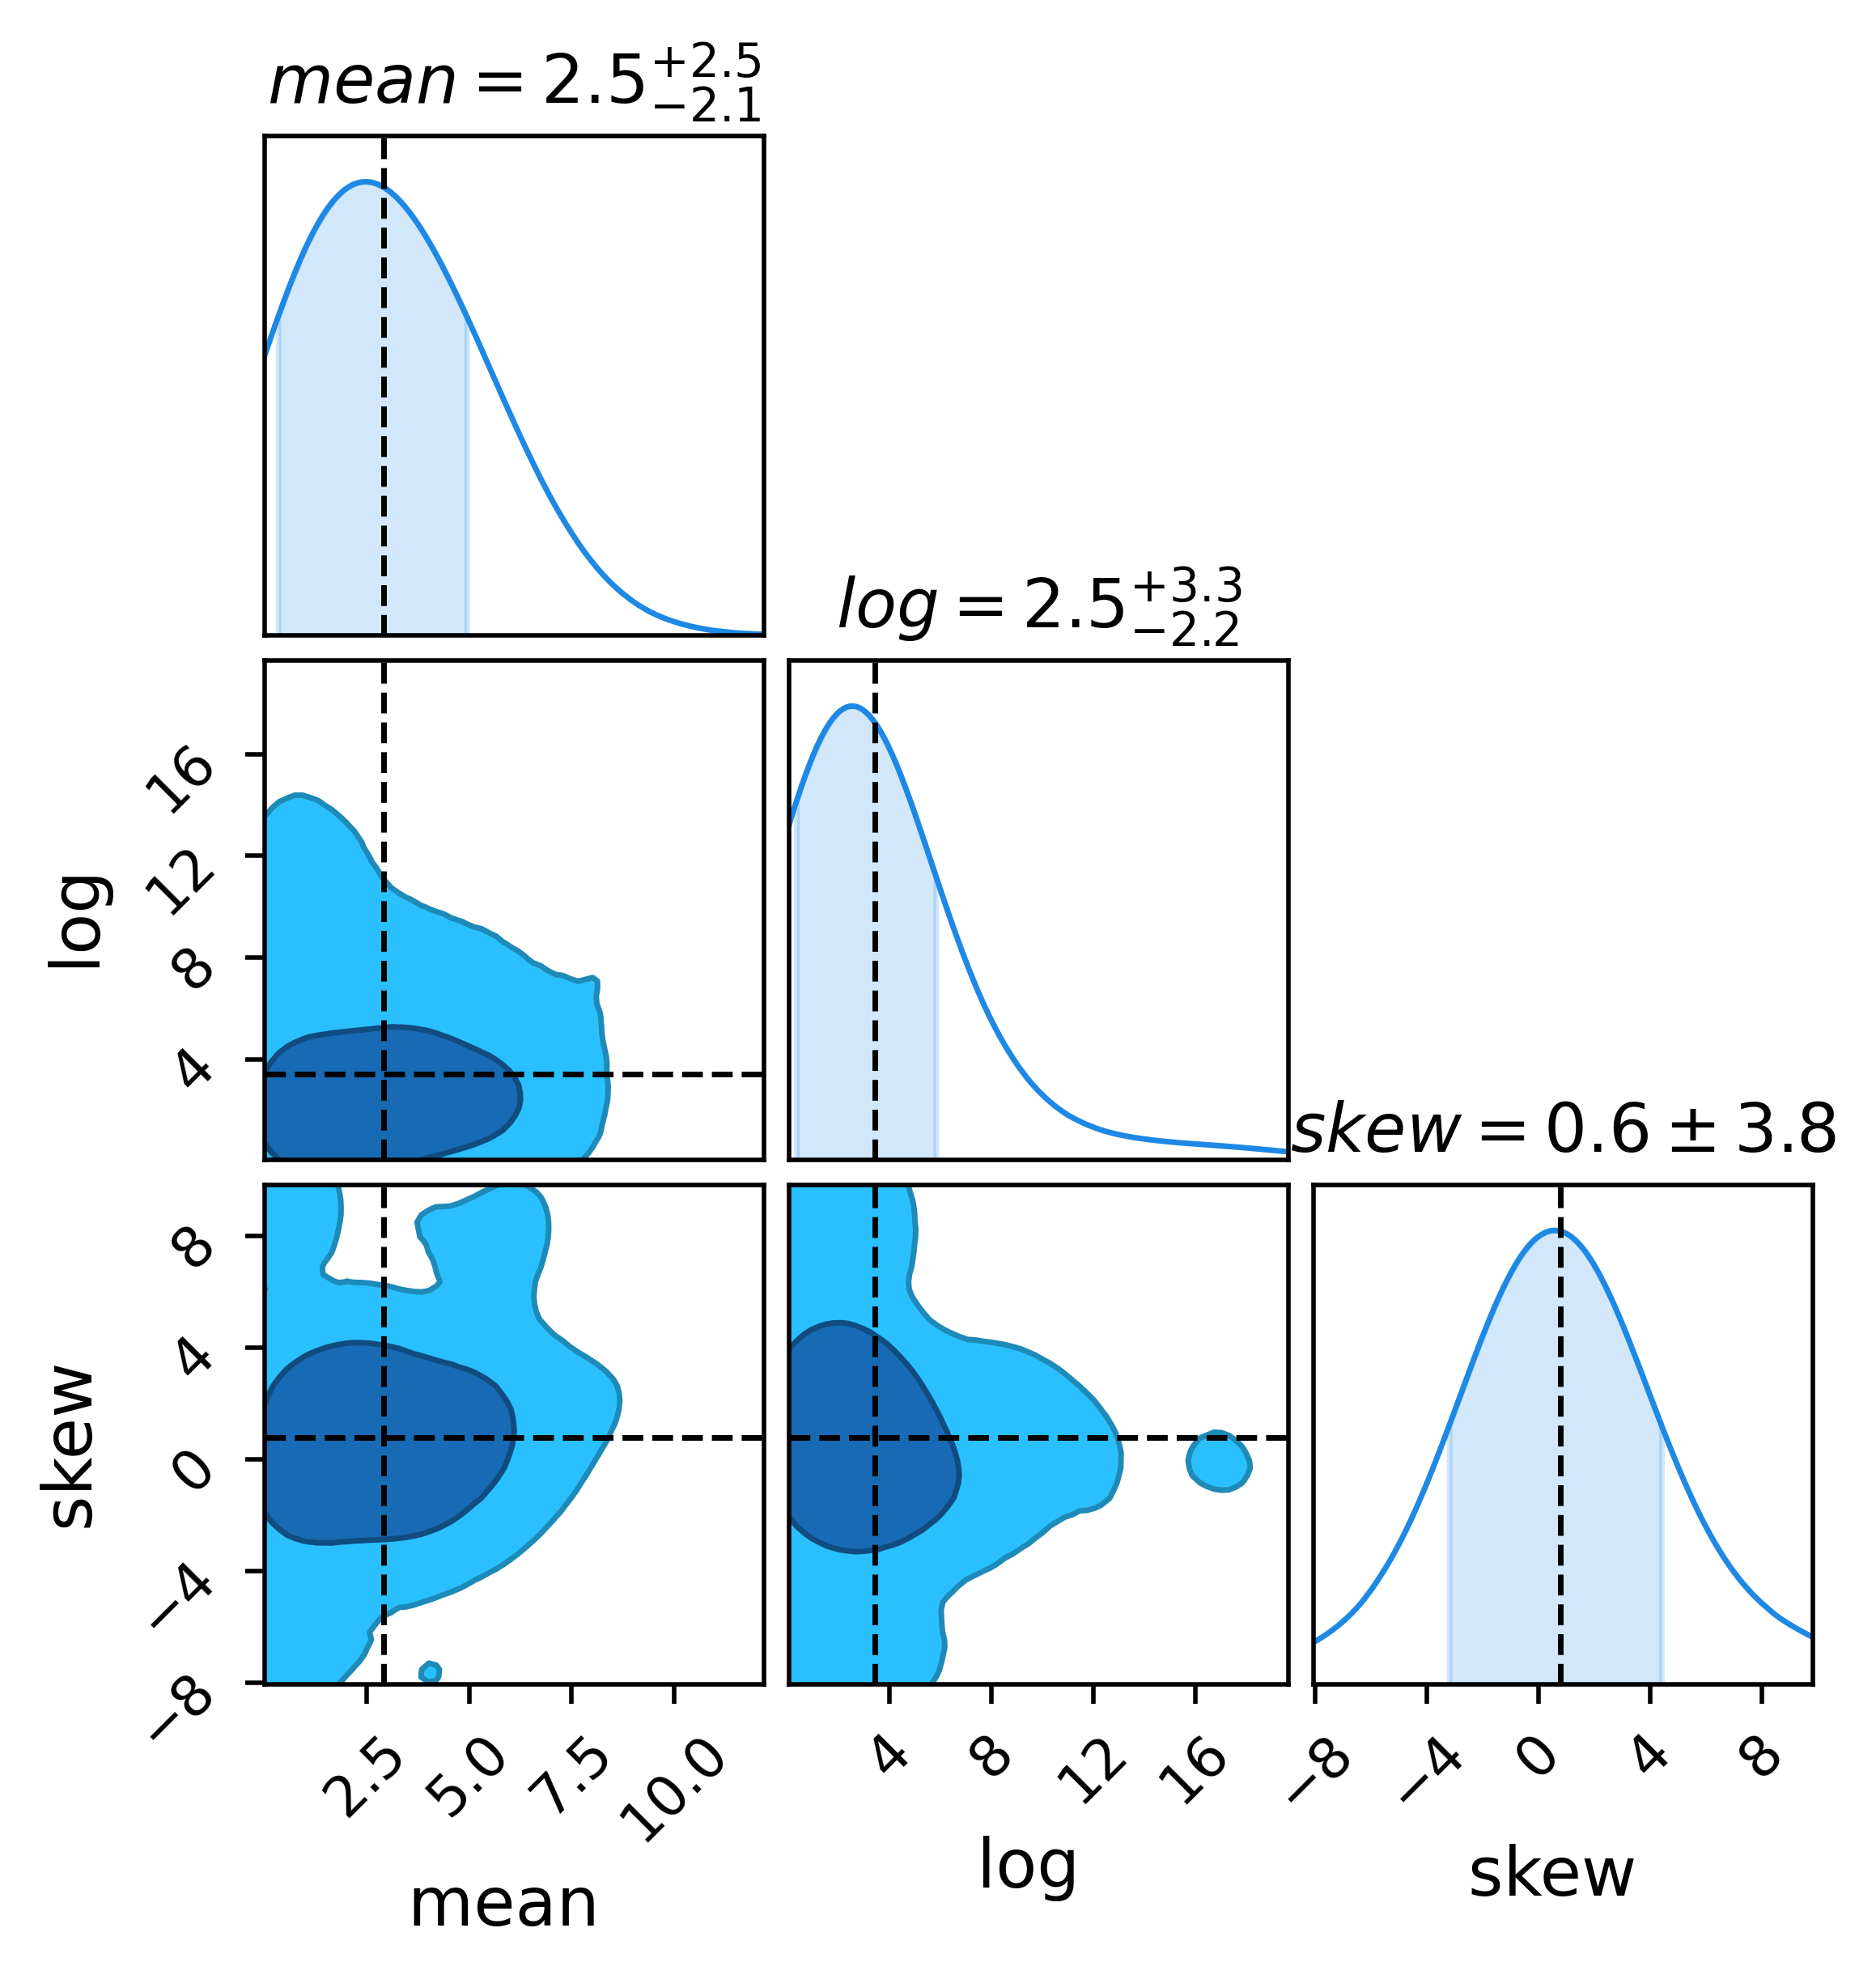

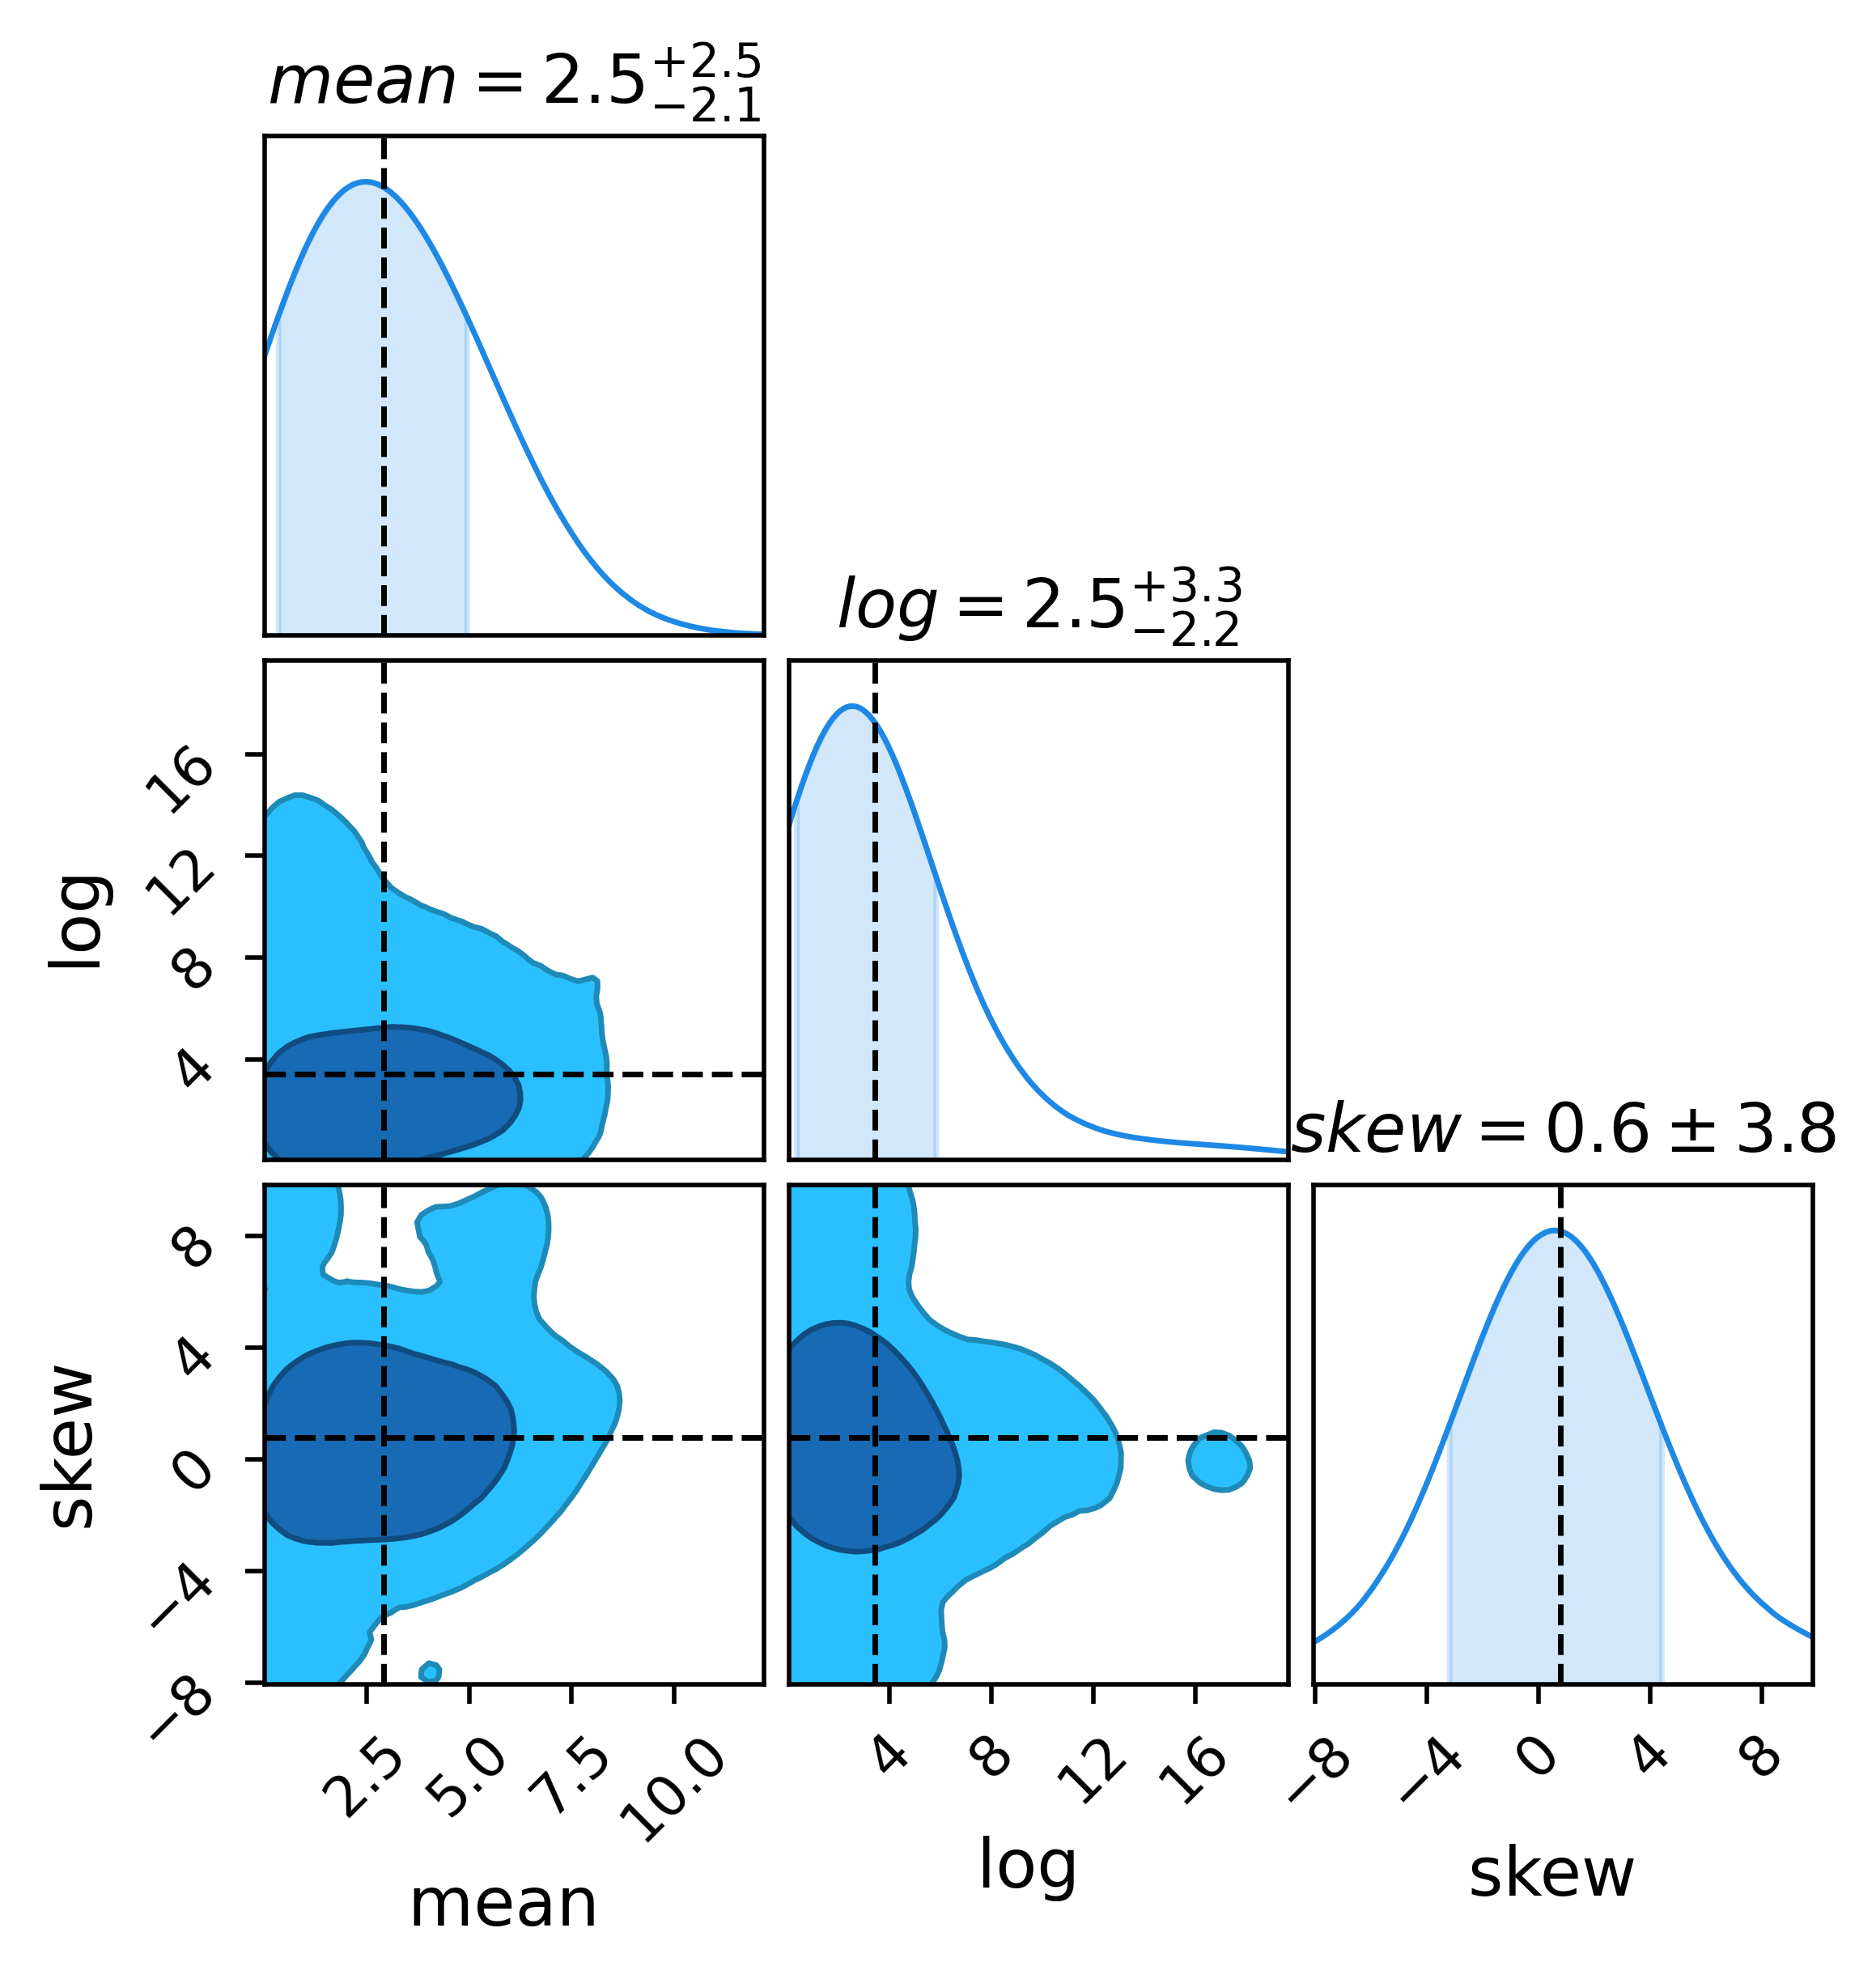

In [184]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(samp2d, parameters=["mean", "log", "skew"])
c.configure(kde=[2.5], colors=["#1E88E5"], shade=[True])
truth_values = [np.mean(sampler.chain[:,:,0].T), np.mean(sampler.chain[:,:,1].T), np.mean(sampler.chain[:,:,2].T)]  
c.plotter.plot(truth=truth_values)

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 249.66it/s]


<Axes: ylabel='Density'>

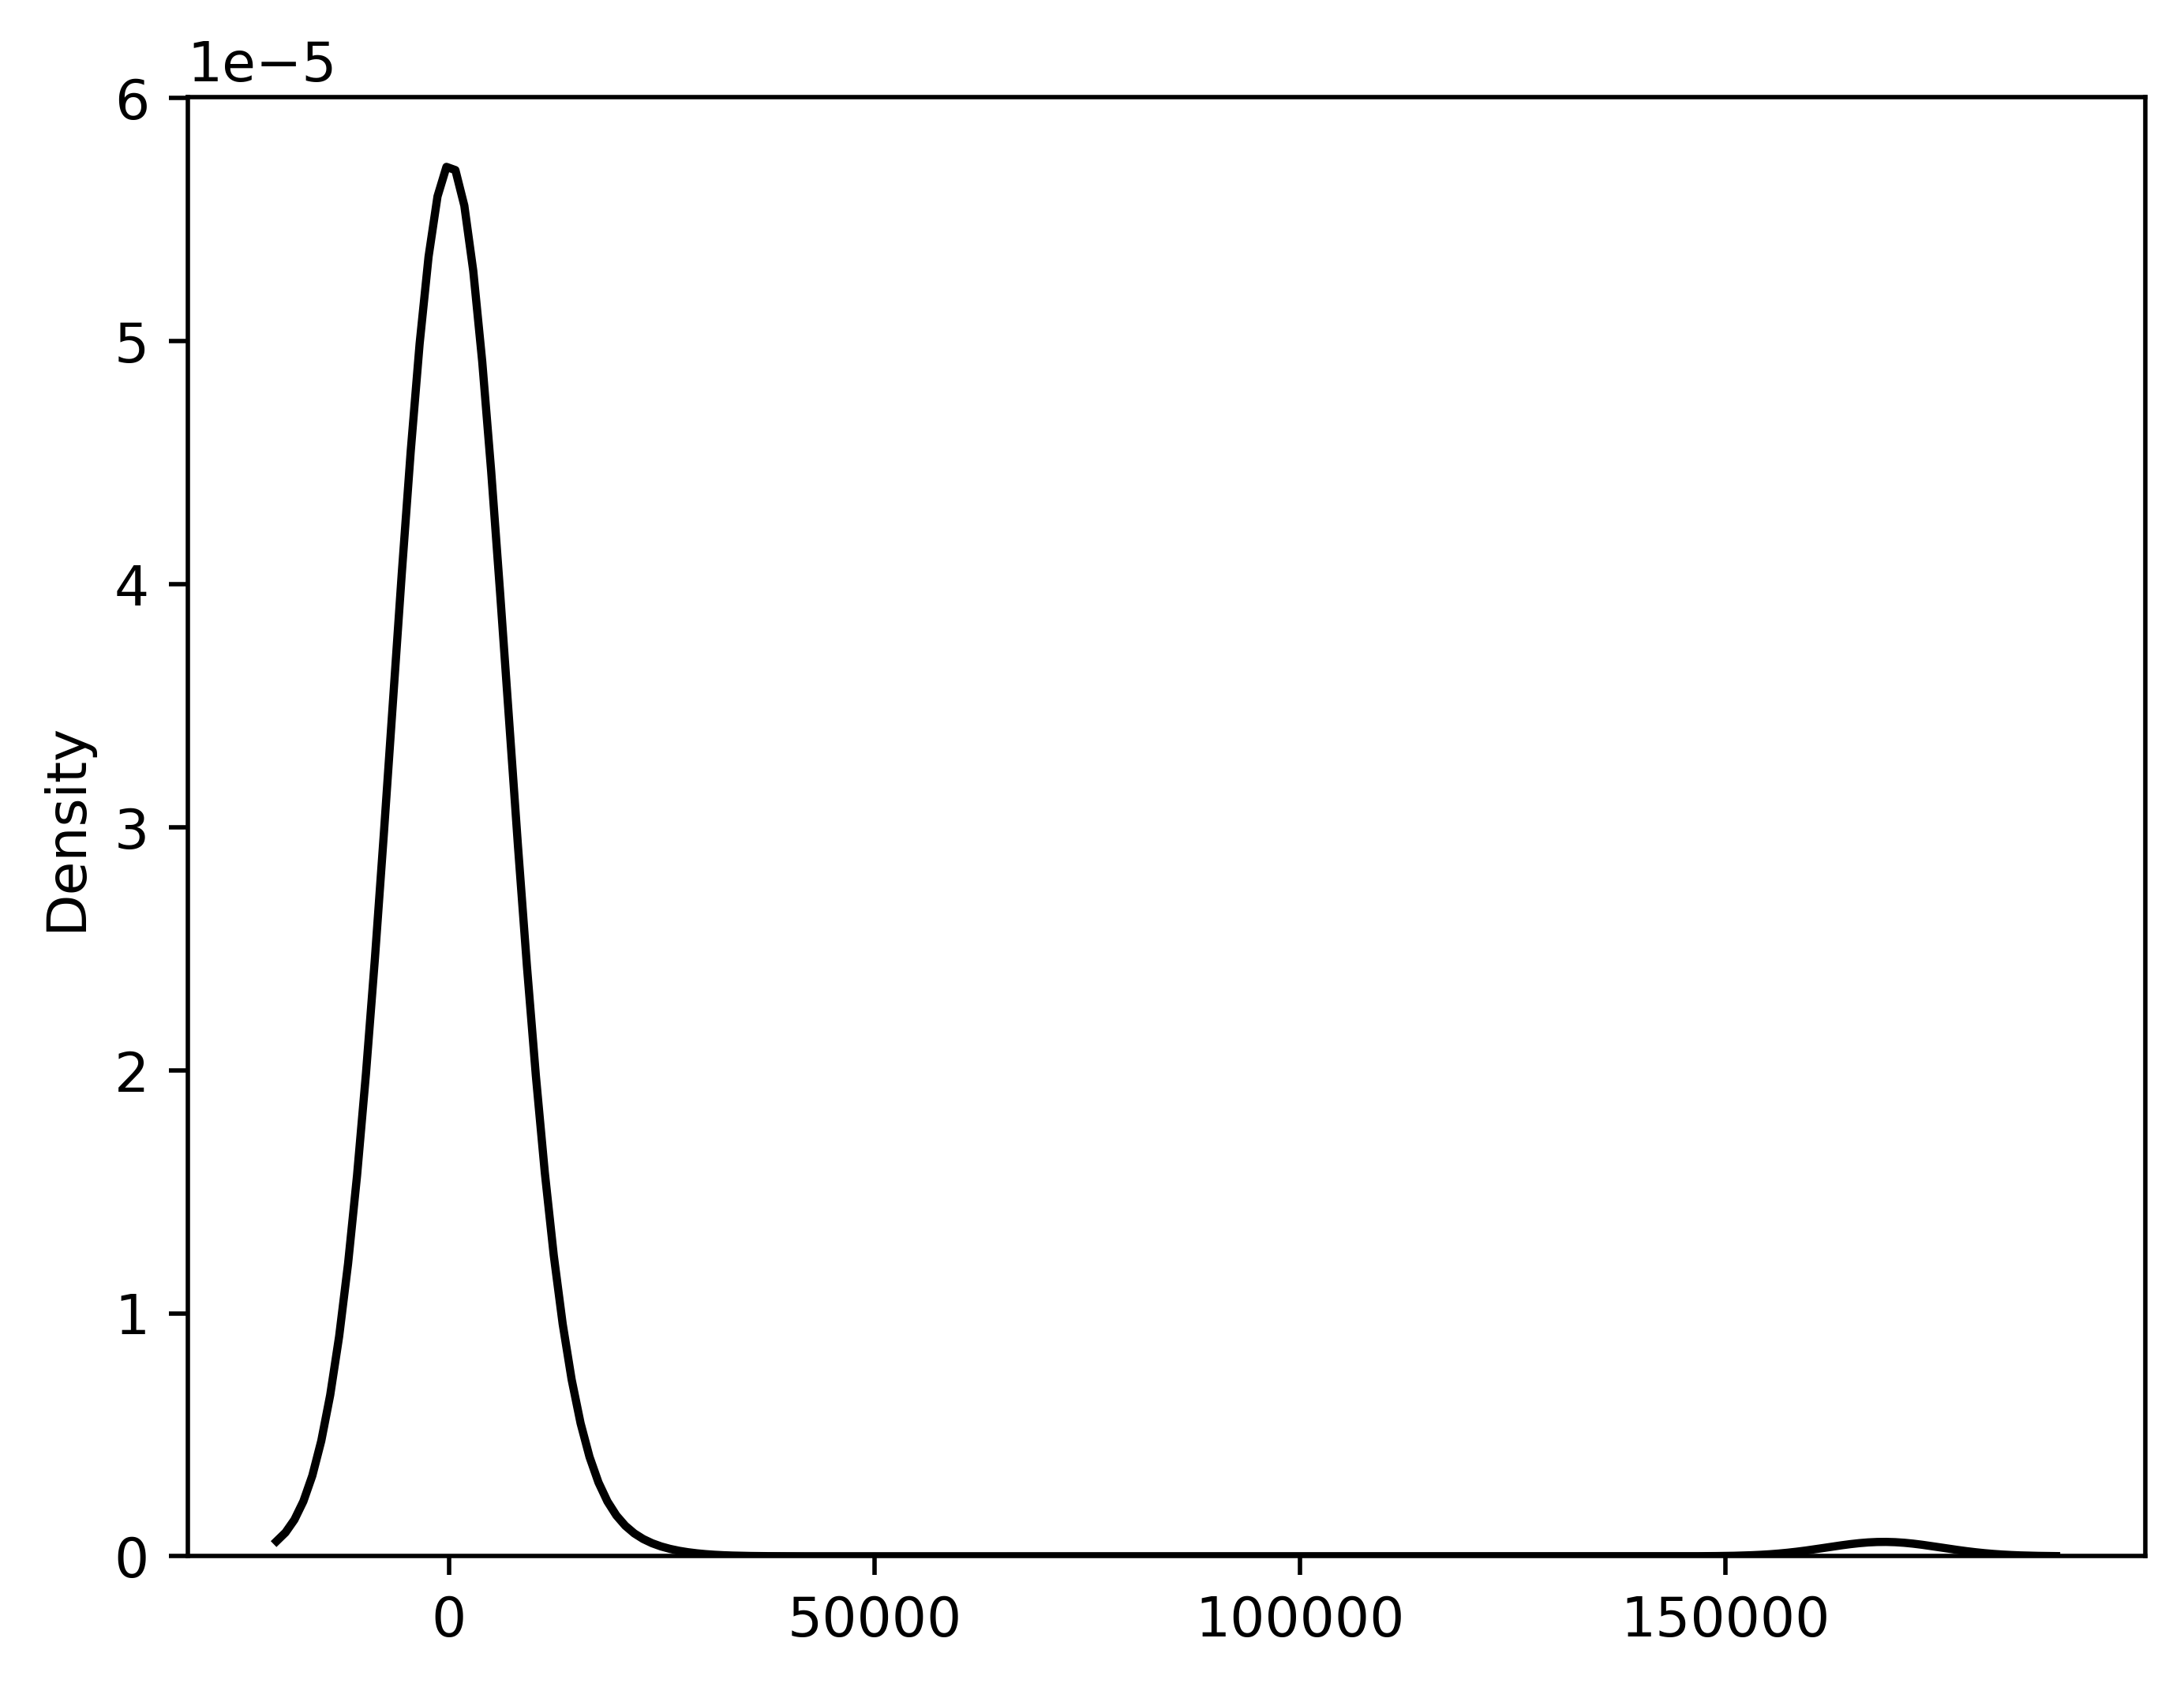

In [182]:
specificg = 3
W = 30
n = 0.1
shield = 0.05
slope = 0.05
S = 0.01
meanlog = np.mean(sampler.chain[:,:,0].T)
stdlog = np.mean(sampler.chain[:,:,1].T)
skewlog = np.mean(sampler.chain[:,:,2].T)
diameters_in_range_all_iterations = hkm([np.mean(sampler.chain[:,:,0].T), np.mean(sampler.chain[:,:,1].T), np.mean(sampler.chain[:,:,2].T)])
discharge_in_range_all_iterations = stress([np.mean(sampler.chain[:,:,0].T), np.mean(sampler.chain[:,:,1].T), np.mean(sampler.chain[:,:,2].T)])
heightgraph = [s/(9810*slope) for s in discharge_in_range_all_iterations]
manningdischargegraph = [((((W*H)/(W+2*H))**(2/3)*S**(1/2))/n)*W*H for H in heightgraph]
#sns.kdeplot(manningdischargegraph)
sns.kdeplot(manningdischargegraph,color="black")

/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_68839/329328269.py:73: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 1000])


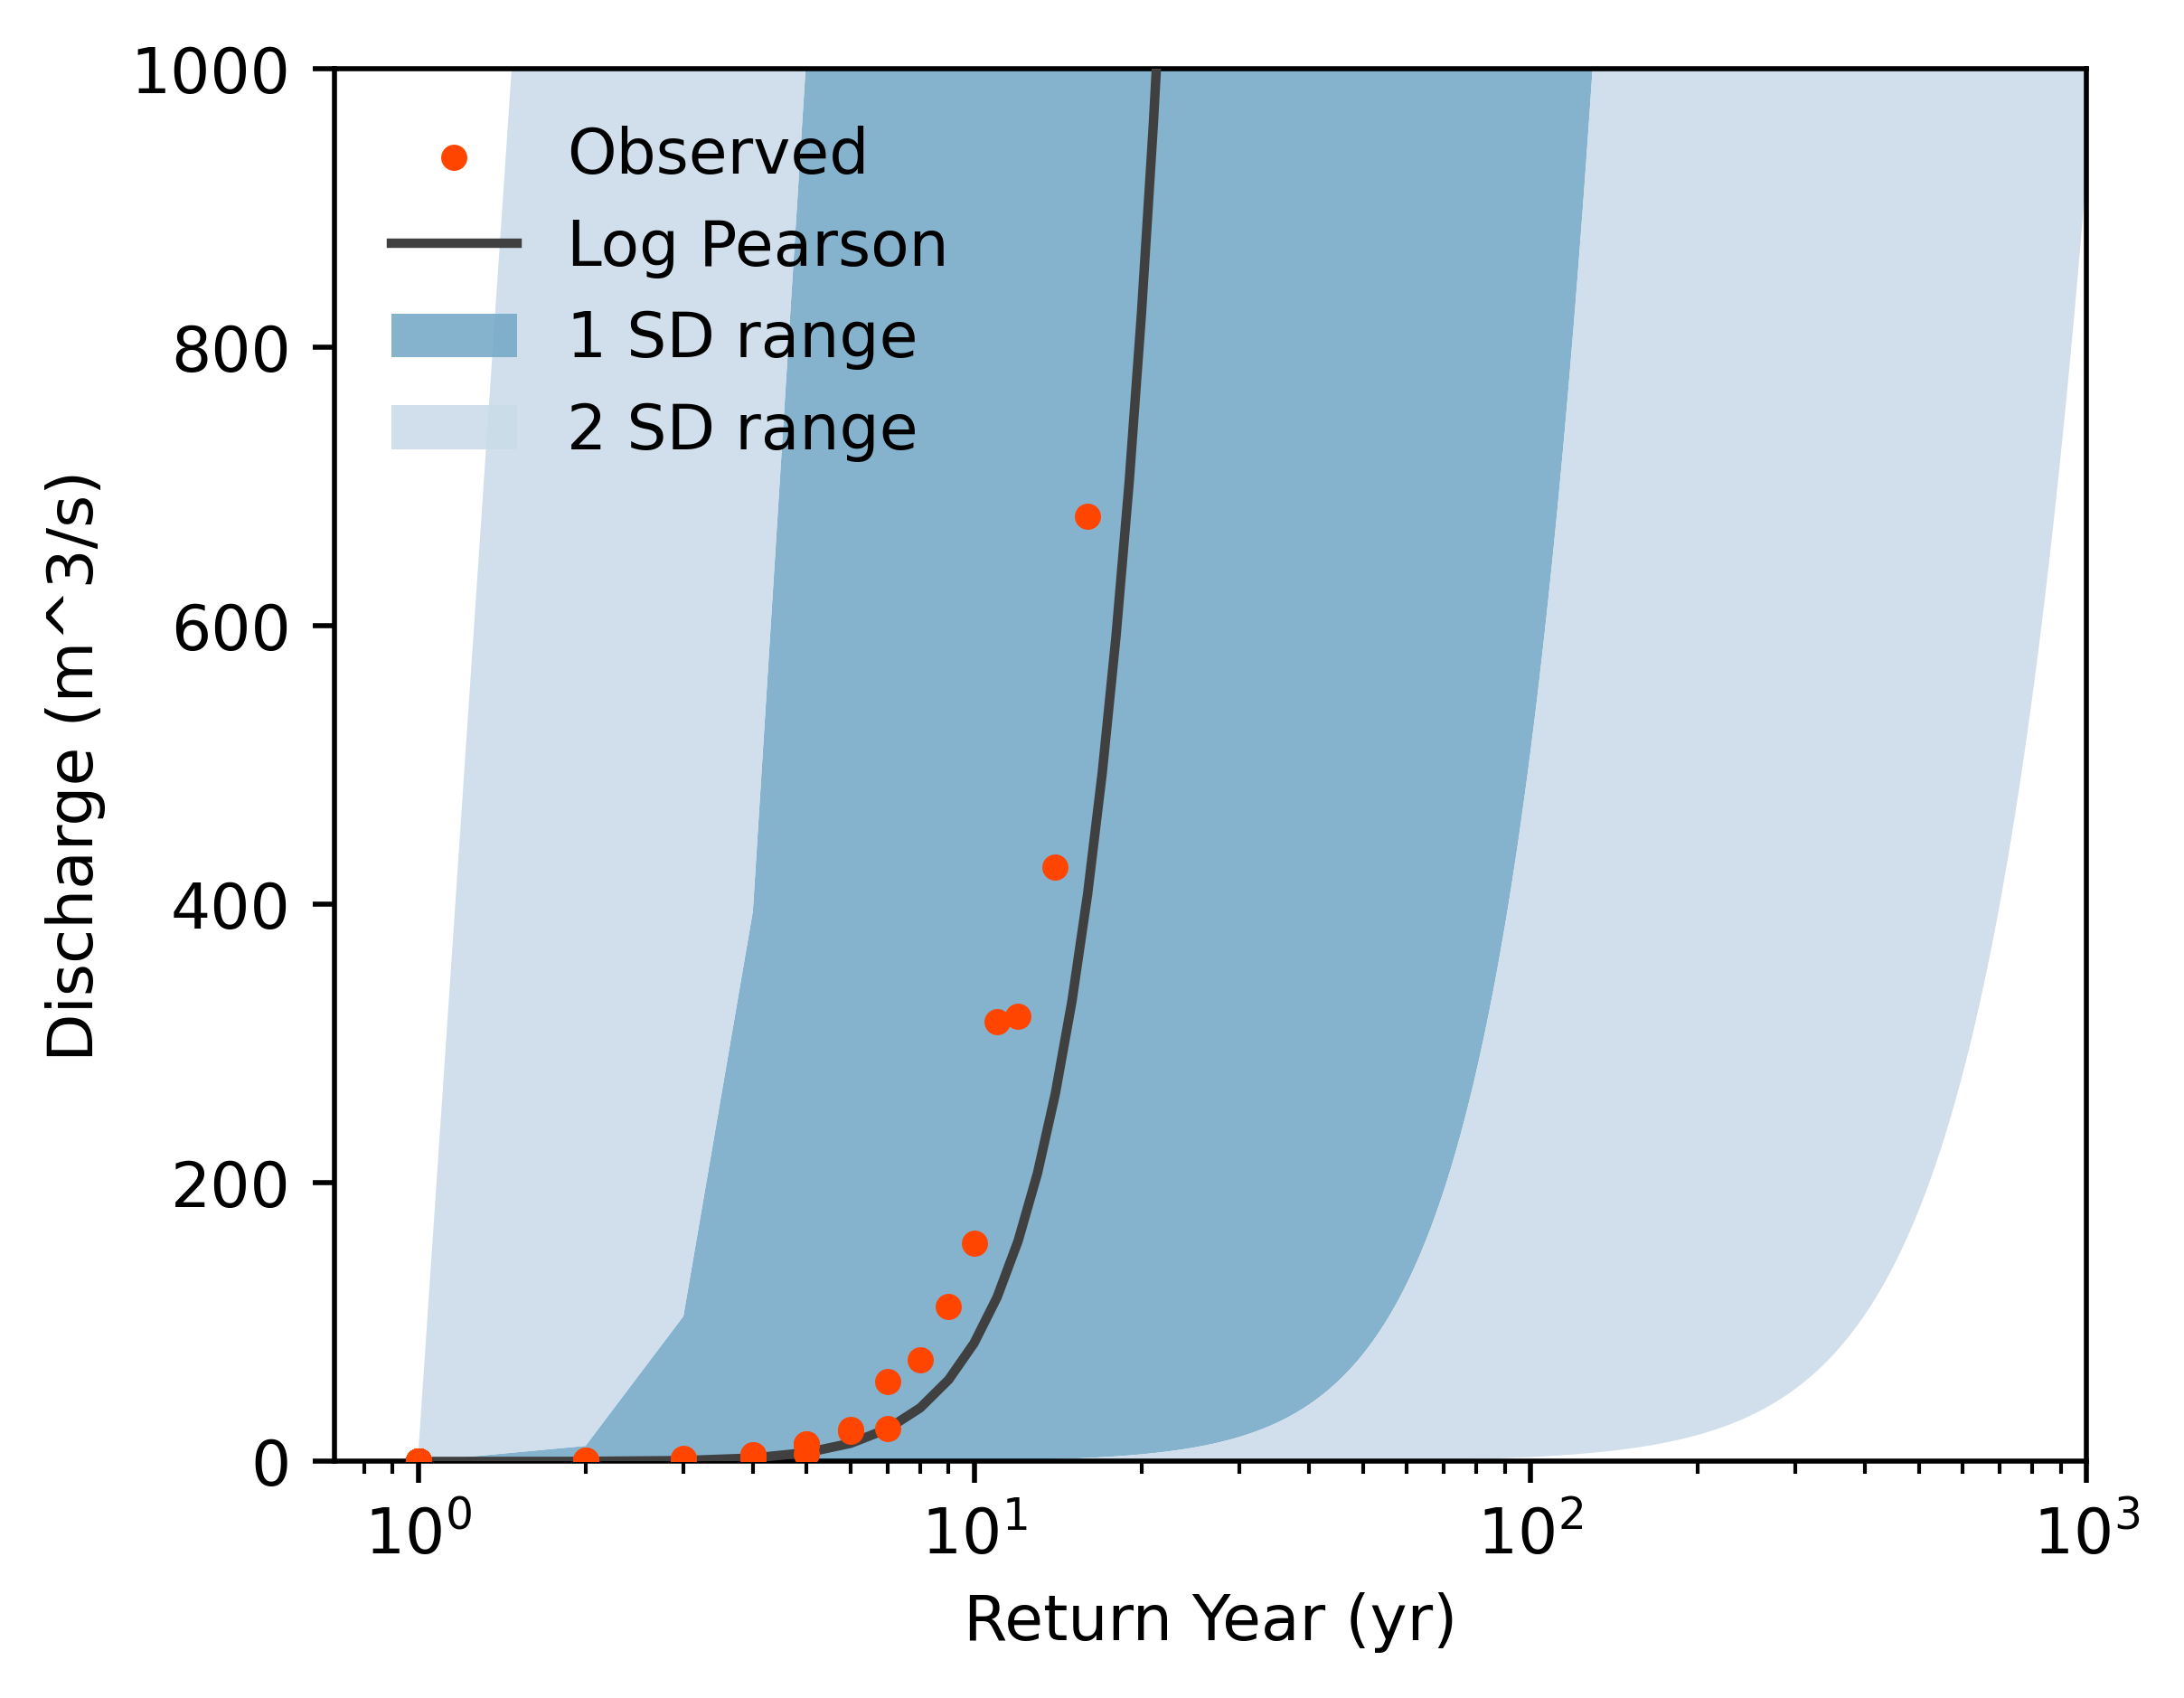

In [183]:
year_range = list(range(2022-100, 2022))

result_df = pd.DataFrame({
    'Year': year_range,
    'Max_Value_m': manningdischargegraph
})
sort_rain = result_df.sort_values(by =['Max_Value_m'], ascending=False).reset_index(drop=True)
rank = np.zeros((len(sort_rain), 3))
for i in range(len(sort_rain)):
    rank[i, 0] = i + 1
    rank[i, 1] = (i + 1)/(len(sort_rain)+1)
    rank[i, 2] = 1/rank[i, 1]

rank = pd.DataFrame(rank, columns=['rank', 'probability', 'return_year'])
rank[['rank', 'return_year']] = rank[['rank', 'return_year']].astype(int)
rank_rain = pd.concat([sort_rain, rank], axis=1)

rain = np.array(rank_rain['Max_Value_m'])
std = np.std(rain)
u = np.mean(rain)
skew = sp.skew(np.log10(rain))

# Extending the return years to 100
extended_re_year = np.arange(1, 1001)

z = np.zeros(len(extended_re_year))
k3 = np.zeros(len(extended_re_year))
lp3 = np.zeros(len(extended_re_year))

for i in range(len(extended_re_year)):
    if extended_re_year[i] != 1:
        z[i] = sp.norm.ppf(1 - (1/extended_re_year[i]))
        k3[i] = -(np.sqrt(6)/np.pi)*(0.5772 + np.log(np.log(extended_re_year[i] / (extended_re_year[i]-1)))) 
    else:
        z[i] = sp.norm.ppf(1-(1/(extended_re_year[i]+0.1)))
        k3[i] = -(np.sqrt(6)/np.pi)*(0.5772 + np.log(np.log((extended_re_year[i]+0.1)/(extended_re_year[i]+0.1-1))))
    lp3[i] = 2/skew * (np.power((z[i] - skew/6)*skew/6+1, 3)-1)

# Standard deviation for log-transformed data
std_log = np.std(np.log10(rain))

extended_model_rain = np.zeros((len(extended_re_year), 7))
for i in range(len(extended_model_rain)):
    extended_model_rain[i][0] = u + z[i]* std
    extended_model_rain[i][1] = u + k3[i] * std
    extended_model_rain[i][2] = np.power(10, np.mean(np.log10(rain)) + lp3[i] * std_log)
    extended_model_rain[i][3] = np.power(10, np.mean(np.log10(rain)) + (lp3[i] + 1) * std_log)
    extended_model_rain[i][4] = np.power(10, np.mean(np.log10(rain)) + (lp3[i] - 1) * std_log)
    extended_model_rain[i][5] = np.power(10, np.mean(np.log10(rain)) + (lp3[i] + 2) * std_log)
    extended_model_rain[i][6] = np.power(10, np.mean(np.log10(rain)) + (lp3[i] - 2) * std_log)

# Creating a DataFrame for extended data
extended_pd_rain = pd.DataFrame(extended_model_rain, columns=['Normal', 'Gumbel', 'LogPearson', 'LogPearson+1SD', 'LogPearson-1SD', 'LogPearson+2SD', 'LogPearson-2SD'])

fig, ax1 = plt.subplots(figsize=(5, 4))

# Plotting
plt.scatter(rank_rain['return_year'], rank_rain['Max_Value_m'], s=10, color='orangered', label='Observed',zorder=100)
plt.plot(extended_re_year, extended_pd_rain['LogPearson'], color='#404040', label='Log Pearson',linestyle="-",zorder=50)

# Shading between curves
plt.fill_between(extended_re_year, extended_pd_rain['LogPearson-1SD'], extended_pd_rain['LogPearson+1SD'], color='#78aac8', alpha=0.9, lw = 0,label='1 SD range')
plt.fill_between(extended_re_year, extended_pd_rain['LogPearson-2SD'], extended_pd_rain['LogPearson-1SD'], color='#cbdce9', alpha=0.9,lw = 0,label='2 SD range')
plt.fill_between(extended_re_year, extended_pd_rain['LogPearson+1SD'], extended_pd_rain['LogPearson+2SD'], color='#cbdce9', alpha=0.9,lw = 0)

#plt.xscale('log') 

plt.xscale('log') 

plt.legend()
plt.xlabel('Return Year (yr)')
plt.ylabel('Discharge (m^3/s)')
plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.legend(loc="upper left", frameon=False)  # Set the legend to top left and remove the frame
plt.show()